In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import vgg19, VGG19_Weights

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# 1. data

## 1.1. load image

In [3]:
content_img_path = "./notebook_images/dancing.jpg"

content_img = Image.open(content_img_path)

## 1.2 transform as tensor

In [4]:
img_size = 512 if torch.cuda.is_available() else 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

content_tensor = transform(content_img).unsqueeze(0)
print(f"content_tensor shape: {content_tensor.shape}")

content_tensor shape: torch.Size([1, 3, 128, 128])


## 1.3. make noise tensor

In [5]:
noise_tensor = torch.randn(content_tensor.size())
print(f"noise_tensor shape: {noise_tensor.shape}")

noise_tensor shape: torch.Size([1, 3, 128, 128])


## 1.4. visualize

In [6]:
untransform = transforms.Compose([
    transforms.ToPILImage(),
])

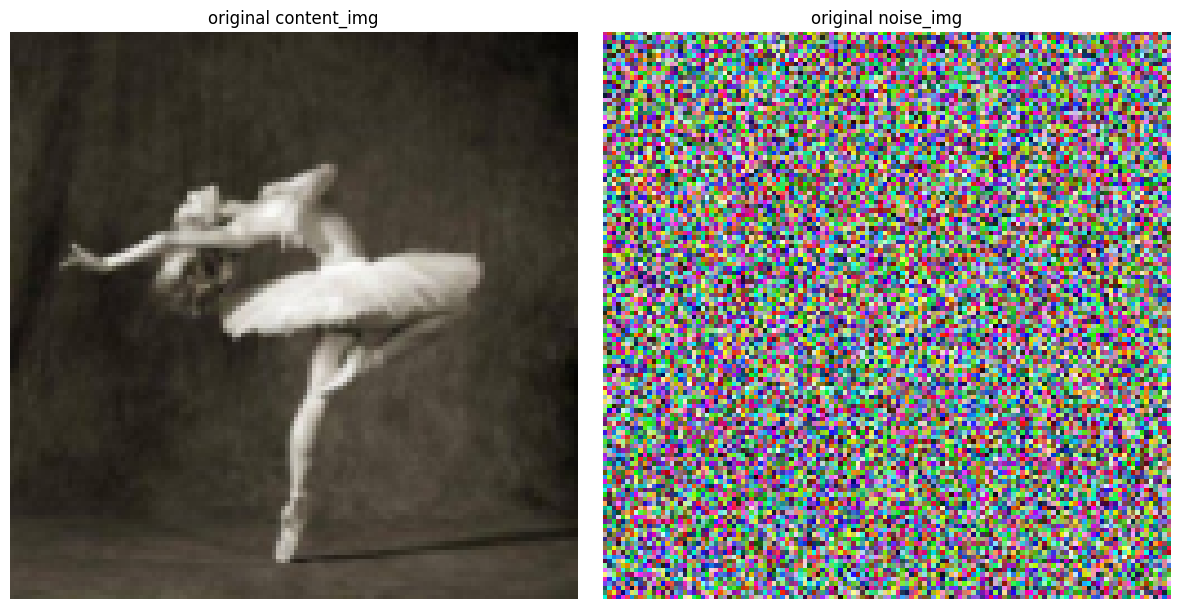

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(content_tensor.squeeze(0)))
plt.title(f"original content_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title(f"original noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()

# 2. model

## 2.1. load pre-trained vgg19

In [8]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

## 2.2. add normalization layer

In [9]:
ImageNet_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
ImageNet_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

## 2.3. slice vgg19

In [10]:
model = nn.Sequential(Normalization(ImageNet_mean, ImageNet_std))
i = 0
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False) # inplace=True <- backprop error
        name = f"relu_{i}"
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2) # follow the paper
        name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
        name = f"bn_{i}"

    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 2.4. visualize

In [11]:
def visualize_feature_maps(content_results, noise_results, 
                           layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'], title=""):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle(title, fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        # Content feature map
        content_feature_map = content_results[layer].squeeze(0).cpu()
        content_mean_map = torch.mean(content_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(content_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Content)")
        axes[i][0].axis("off")

        # Noise feature map
        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [12]:
model.eval()

content_feature_map = content_tensor.clone().to(device)
noise_feature_map = noise_tensor.clone().to(device)

content_feature_maps = {}
noise_feature_maps = {}

for name, layer in model.named_children():
    content_feature_map = layer(content_feature_map)
    content_feature_maps[name] = content_feature_map

    noise_feature_map = layer(noise_feature_map)
    noise_feature_maps[name] = noise_feature_map

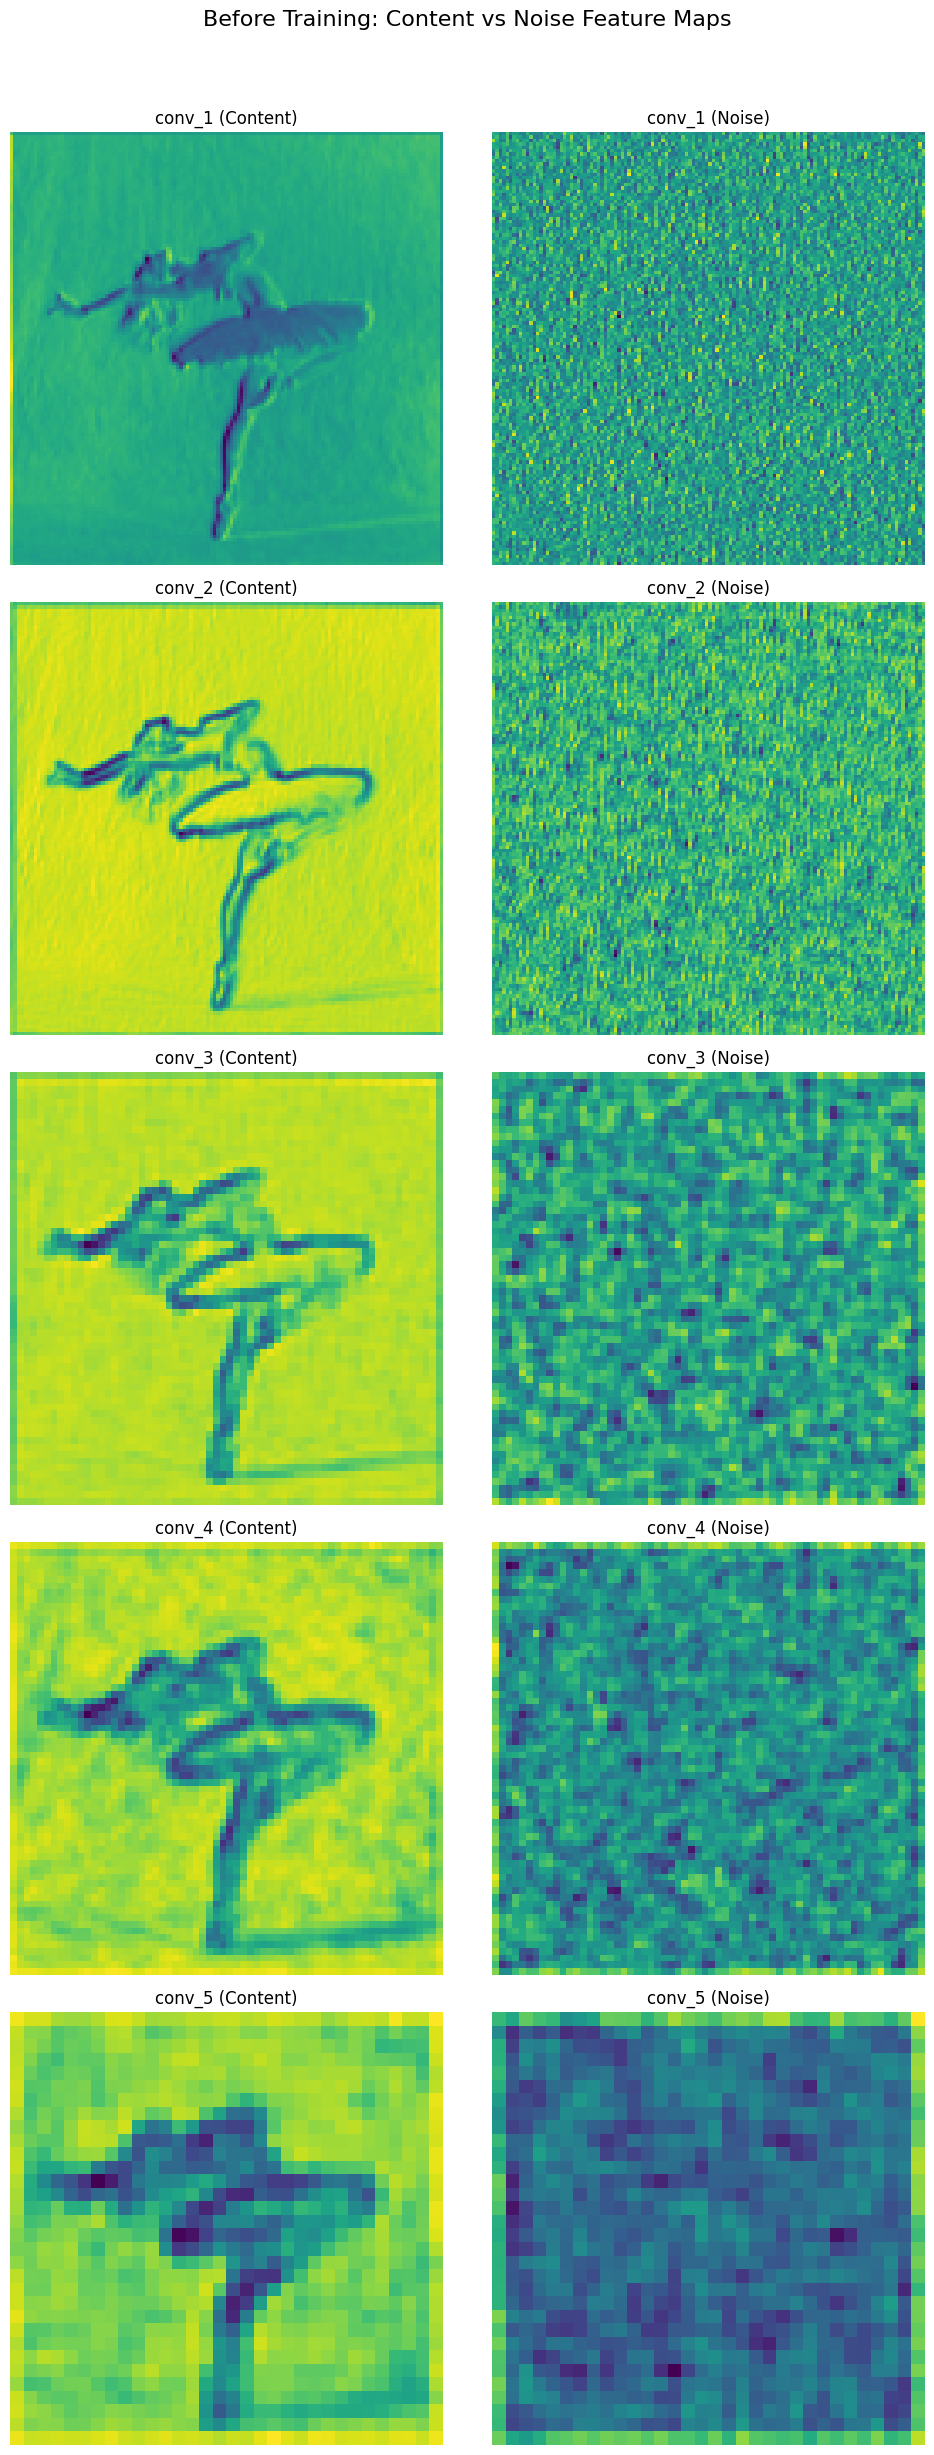

In [13]:
visualize_feature_maps(content_feature_maps, noise_feature_maps, title="Before Training: Content vs Noise Feature Maps")

# 3. loss

## 3.1. mse-loss

<img src="./notebook_images/mse_loss.jpg">

In [14]:
import torch.nn.functional as F

def content_loss(input, target):
    loss = F.mse_loss(input, target)

    return loss

# 4. train

## 4.1. training

In [15]:
model.eval()

content_feature_map = content_tensor.clone().to(device)

content_feature_maps = {}

for name, layer in model.named_children():
    content_feature_map = layer(content_feature_map)
    content_feature_maps[name] = content_feature_map

In [16]:
content_layers = ['conv_4']


def train(model, content_feature_maps, epochs=300):
    required_noise_feature_map = noise_tensor.clone().to(device)
    required_noise_feature_map.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = optim.LBFGS([required_noise_feature_map])
    epoch = 0

    def closure():
        nonlocal epoch
        with torch.no_grad():
            required_noise_feature_map.clamp_(0, 1)
        output = required_noise_feature_map

        optimizer.zero_grad()
        content_losses = 0.0
        for name, layer in model.named_children():
            output = layer(output)

            if name in content_layers:
                content_losses += content_loss(output, content_feature_maps[name].detach())
        
        content_losses.backward()

        epoch += 1
        if epoch % 50 == 0:
            print(f"epoch {epoch}/{epochs}:")
            print(f"content-loss: {content_losses.item():.4f}")
            print()

        return content_losses
    
    while epoch <= epochs:
        optimizer.step(closure)

    with torch.no_grad():
        required_noise_feature_map.clamp_(0, 1)

    return required_noise_feature_map

required_noise_feature_map = train(model, content_feature_maps)

epoch 50/300:
content-loss: 0.2248

epoch 100/300:
content-loss: 0.0918

epoch 150/300:
content-loss: 0.0375

epoch 200/300:
content-loss: 0.0172

epoch 250/300:
content-loss: 0.0067

epoch 300/300:
content-loss: 0.0039



## 4.2. visualize

In [17]:
noise_feature_map = required_noise_feature_map
noise_feature_maps = {}

for name, layer in model.named_children():
    noise_feature_map = layer(noise_feature_map)
    noise_feature_maps[name] = noise_feature_map

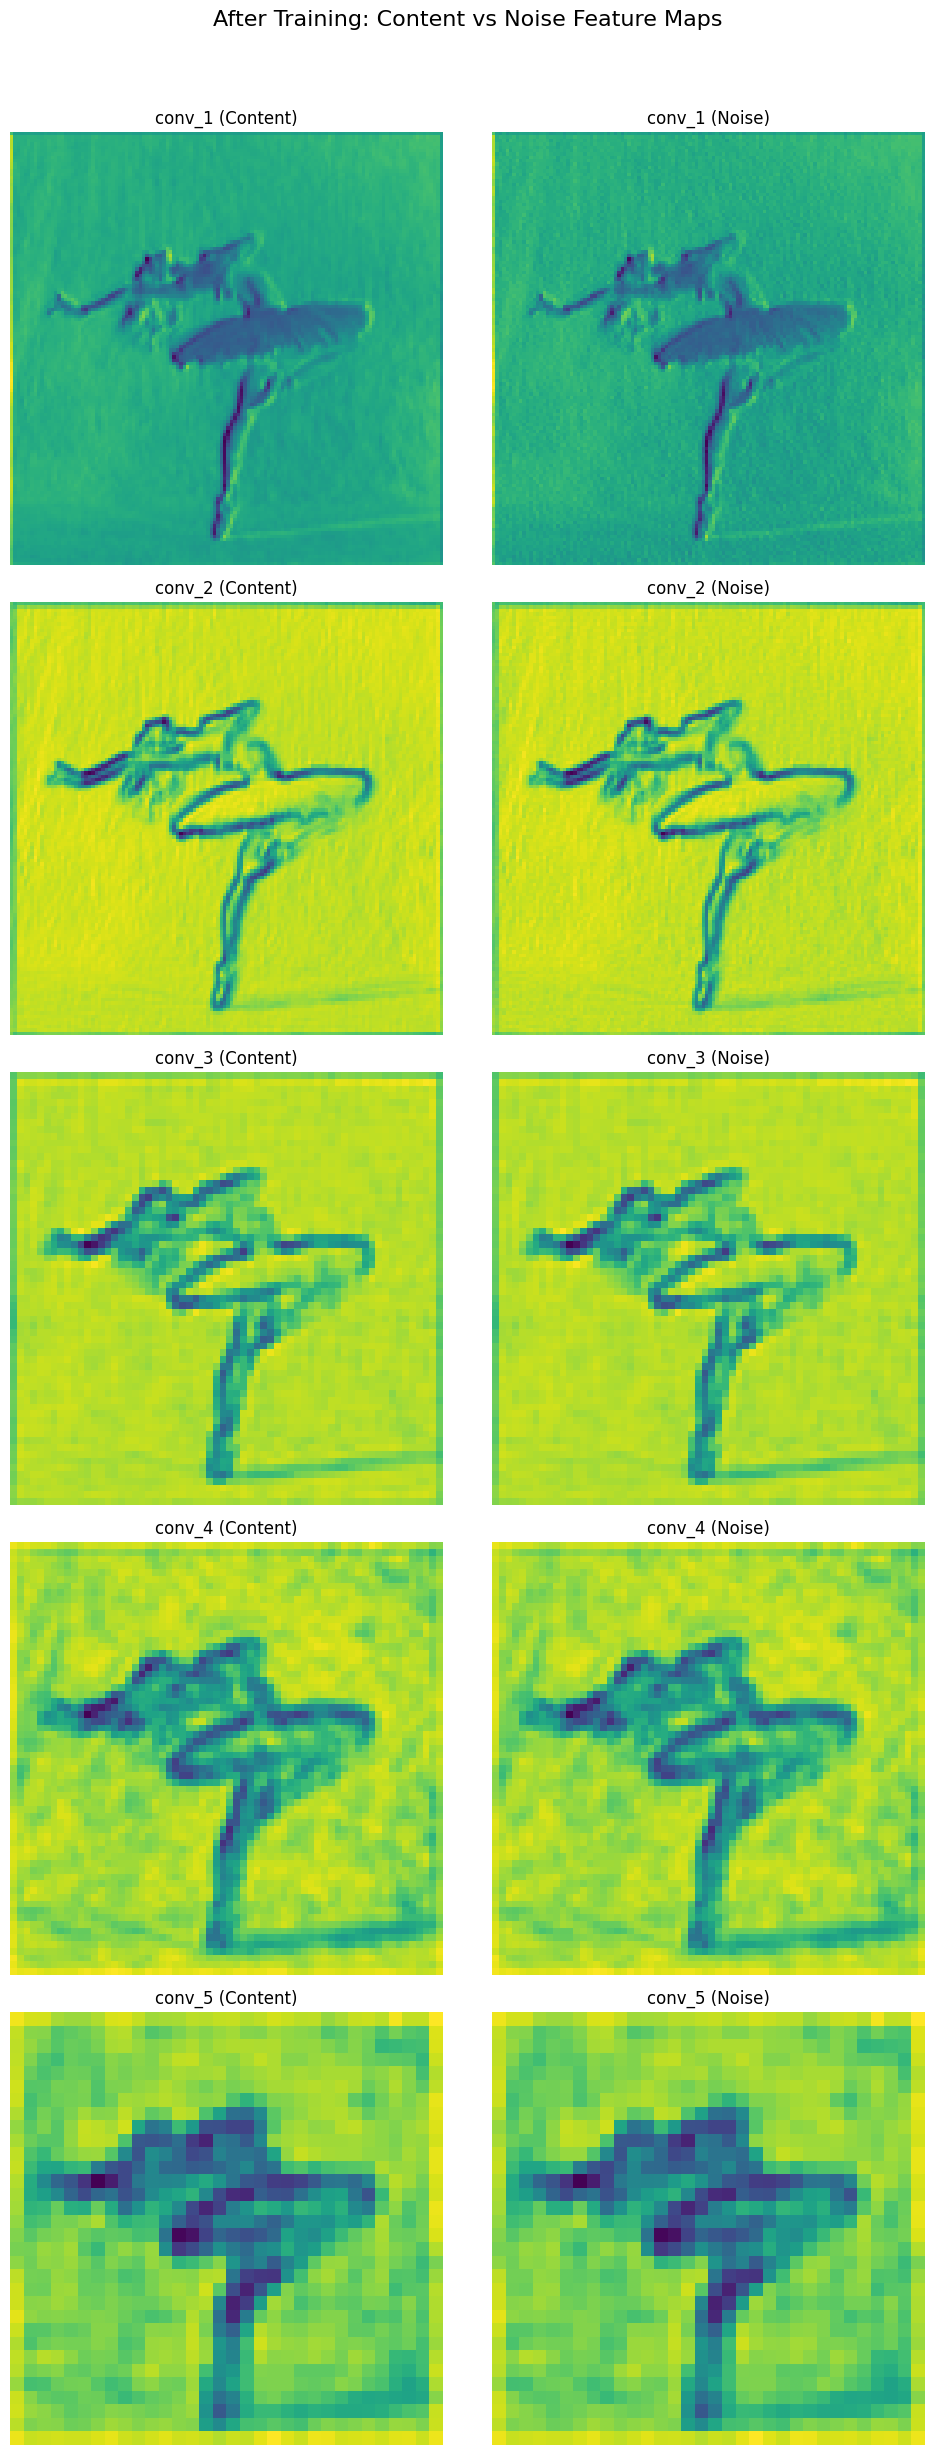

In [18]:
visualize_feature_maps(content_feature_maps, noise_feature_maps, title="After Training: Content vs Noise Feature Maps")

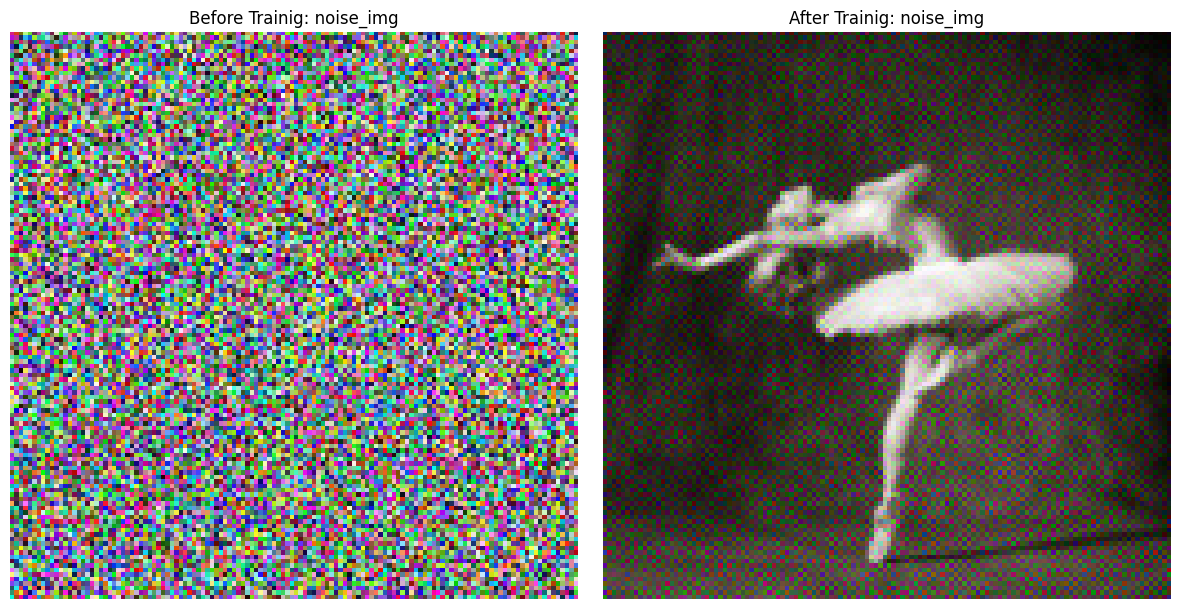

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("Before Trainig: noise_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(required_noise_feature_map.squeeze(0)))
plt.title("After Trainig: noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()